# **English-to-Portuguese Neural Machine Translation (NMT) with LSTM-RNN Architecture**

Here, we will build an English-to-Portuguese neural machine translation (NMT) model using Long Short-Term Memory (LSTM) networks with attention. Machine translation is an important task in natural language *processing* and could be useful not only for translating one language to another but also for word sense disambiguation (e.g. determining whether the word "bank" refers to the financial bank, or the land alongside a river). Implementing this using just a Recurrent Neural Network (RNN) with LSTMs can work for short to medium length sentences but can result in vanishing gradients for very long sequences. To help with this, we will be adding an attention mechanism to allow the decoder to access all relevant parts of the input sentence regardless of its length. By completing this assignment, we will:

- Implement an encoder-decoder system with attention
- Build the NMT model from scratch using Tensorflow
- Generate translations using greedy and Minimum Bayes Risk (MBR) decoding

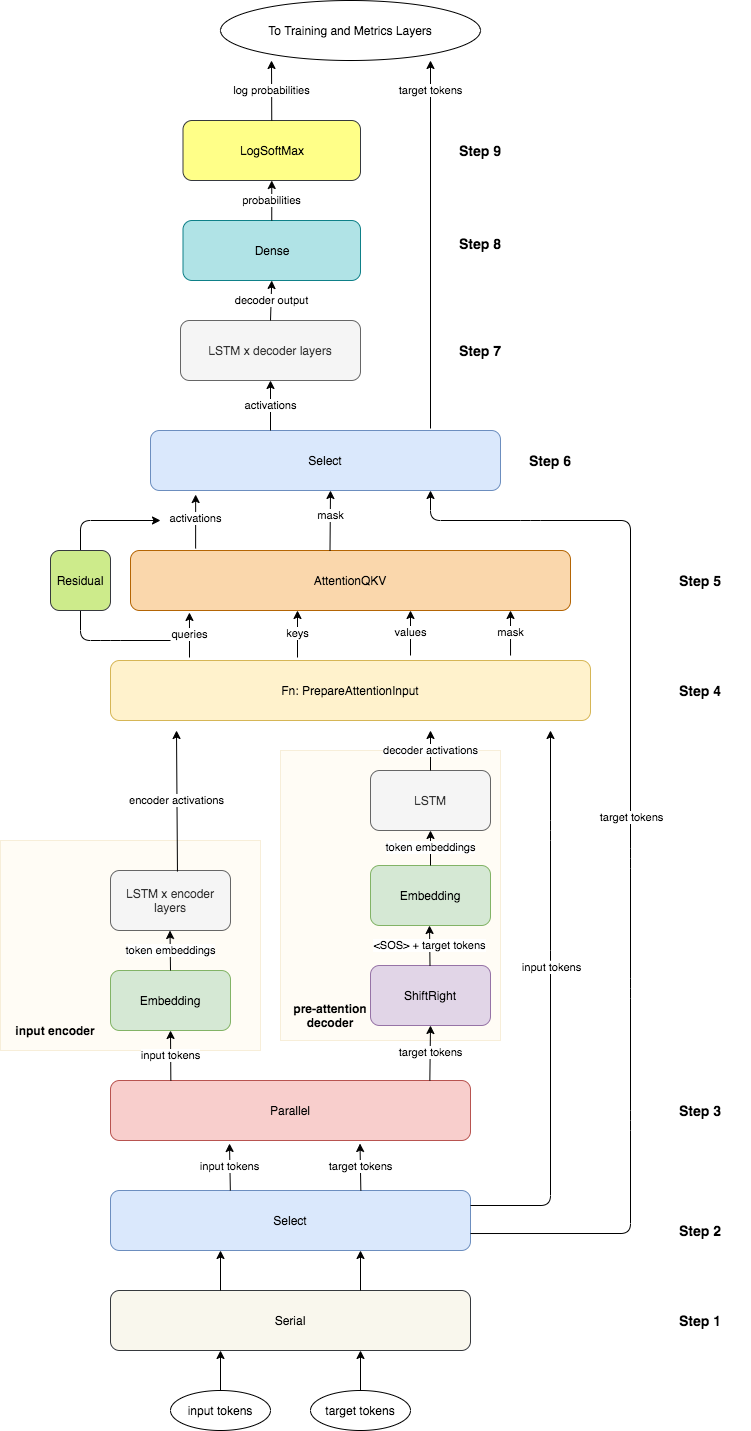

## Table of Contents
- [1 - Data Preparation](#1)
- [2 - NMT model with attention](#2)
    - [2.1 - Encoder](#ex1)
    - [2.2 - CrossAttention](#ex2)
    - [2.3 - Decoder](#ex3)    
    - [2.4 - Translator](#ex4)
- [3 - Training](#3)
- [4 - Using the model for inference ](#4)
    - [4.1 - translate](#ex5)
- [5 - Minimum Bayes-Risk Decoding](#5)
    - [5.1 - rouge1_similarity](#ex6)
    - [5.2 - average_overlap](#ex7)


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Setting this env variable prevents TF warnings from showing up

import numpy as np
import tensorflow as tf
from collections import Counter
from utils import (sentences, train_data, val_data, english_vectorizer, portuguese_vectorizer,
                   masked_loss, masked_acc, tokens_to_text)

In [ ]:
import w1_unittest

<a name="1"></a>
## 1. Data Preparation

The text pre-processing bits have already been taken care of. The steps performed can be summarized as:

- Reading the raw data from the text files
- Cleaning the data (using lowercase, adding space around punctuation, trimming whitespaces, etc)
- Splitting it into training and validation sets
- Adding the start-of-sentence and end-of-sentence tokens to every sentence
- Tokenizing the sentences
- Creating a Tensorflow dataset out of the tokenized sentences

Take a moment to inspect the raw sentences:

In [ ]:
portuguese_sentences, english_sentences = sentences

print(f"English (to translate) sentence:\n\n{english_sentences[-5]}\n")
print(f"Portuguese (translation) sentence:\n\n{portuguese_sentences[-5]}")

We don't have much use for the raw sentences so delete them to save memory:

In [ ]:
del portuguese_sentences
del english_sentences
del sentences

Notice that we imported an `english_vectorizer` and a `portuguese_vectorizer` from `utils.py`. These were created using [tf.keras.layers.TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) and they provide interesting features such as ways to visualize the vocabulary and convert text into tokenized ids and vice versa. In fact, we can inspect the first ten words of the vocabularies for both languages:

In [ ]:
print(f"First 10 words of the english vocabulary:\n\n{english_vectorizer.get_vocabulary()[:10]}\n")
print(f"First 10 words of the portuguese vocabulary:\n\n{portuguese_vectorizer.get_vocabulary()[:10]}")

Notice that the first 4 words are reserved for special words. In order, these are:

- the empty string
- a special token to represent an unknown word
- a special token to represent the start of a sentence
- a special token to represent the end of a sentence

We can see how many words are in a vocabulary by using the `vocabulary_size` method:

In [ ]:
# Size of the vocabulary
vocab_size_por = portuguese_vectorizer.vocabulary_size()
vocab_size_eng = english_vectorizer.vocabulary_size()

print(f"Portuguese vocabulary is made up of {vocab_size_por} words")
print(f"English vocabulary is made up of {vocab_size_eng} words")

We can define [tf.keras.layers.StringLookup](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) objects that will help we map from words to ids and vice versa. Do this for the portuguese vocabulary since this will be useful later on when we decode the predictions from our model:

In [ ]:
# This helps you convert from words to ids
word_to_id = tf.keras.layers.StringLookup(
    vocabulary=portuguese_vectorizer.get_vocabulary(),
    mask_token="",
    oov_token="[UNK]"
)

# This helps you convert from ids to words
id_to_word = tf.keras.layers.StringLookup(
    vocabulary=portuguese_vectorizer.get_vocabulary(),
    mask_token="",
    oov_token="[UNK]",
    invert=True,
)

Try it out for the special tokens and a random word:

In [ ]:
unk_id = word_to_id("[UNK]")
sos_id = word_to_id("[SOS]")
eos_id = word_to_id("[EOS]")
baunilha_id = word_to_id("baunilha")

print(f"The id for the [UNK] token is {unk_id}")
print(f"The id for the [SOS] token is {sos_id}")
print(f"The id for the [EOS] token is {eos_id}")
print(f"The id for baunilha (vanilla) is {baunilha_id}")

The id for the [UNK] token is 1
The id for the [SOS] token is 2
The id for the [EOS] token is 3
The id for baunilha (vanilla) is 7079


Finally take a look at how the data that is going to be fed to the neural network looks like. Both `train_data` and `val_data` are of type `tf.data.Dataset` and are already arranged in batches of 64 examples. To get the first batch out of a tf dataset we can use the `take` method. To get the first example out of the batch we can slice the tensor and use the `numpy` method for nicer printing:

In [ ]:
for (to_translate, sr_translation), translation in train_data.take(1):
    print(f"Tokenized english sentence:\n{to_translate[0, :].numpy()}\n\n")
    print(f"Tokenized portuguese sentence (shifted to the right):\n{sr_translation[0, :].numpy()}\n\n")
    print(f"Tokenized portuguese sentence:\n{translation[0, :].numpy()}\n\n")

Tokenized english sentence:
[   2  210    9  146  123   38    9 1672    4    3    0    0    0    0]


Tokenized portuguese sentence (shifted to the right):
[   2 1085    7  128   11  389   37 2038    4    0    0    0    0    0
    0]


Tokenized portuguese sentence:
[1085    7  128   11  389   37 2038    4    3    0    0    0    0    0
    0]




There are a couple of important details to notice.

- Padding has already been applied to the tensors and the value used for this is 0
- Each example consists of 3 different tensors:
    - The sentence to translate
    - The shifted-to-the-right translation
    - The translation
    
The first two can be considered as the features, while the third one as the target. By doing this our model can perform Teacher Forcing as we saw in the lectures.

Now it is time to begin coding!

<a name="2"></a>
## 2. NMT model with attention

The model we will build uses an encoder-decoder architecture. This Recurrent Neural Network (RNN) takes in a tokenized version of a sentence in its encoder, then passes it on to the decoder for translation. As mentioned in the lectures, just using a a regular sequence-to-sequence model with LSTMs will work effectively for short to medium sentences but will start to degrade for longer ones. We can picture it like the figure below where all of the context of the input sentence is compressed into one vector that is passed into the decoder block. We can see how this will be an issue for very long sentences (e.g. 100 tokens or more) because the context of the first parts of the input will have very little effect on the final vector passed to the decoder.

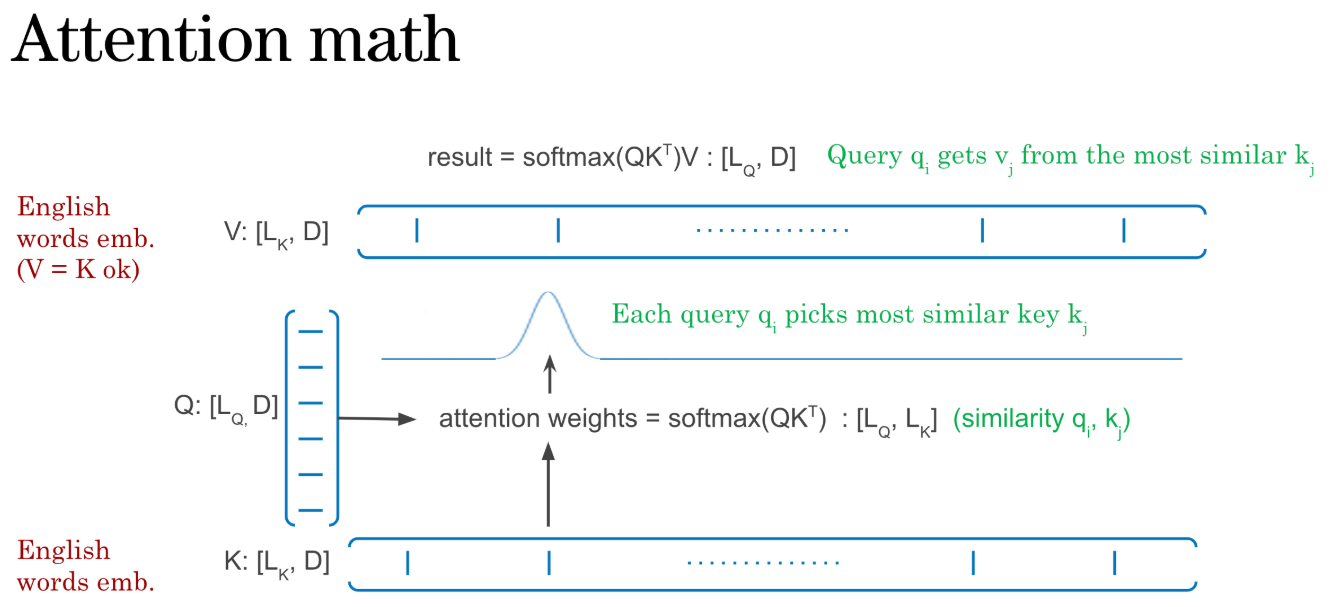

Adding an attention layer to this model avoids this problem by giving the decoder access to all parts of the input sentence. To illustrate, let's just use a 4-word input sentence as shown below. Remember that a hidden state is produced at each timestep of the encoder (represented by the orange rectangles). These are all passed to the attention layer and each are given a score given the current activation (i.e. hidden state) of the decoder. For instance, let's consider the figure below where the first prediction "como" is already made. To produce the next prediction, the attention layer will first receive all the encoder hidden states (i.e. orange rectangles) as well as the decoder hidden state when producing the word "como" (i.e. first green rectangle). Given this information, it will score each of the encoder hidden states to know which one the decoder should focus on to produce the next word. As a result of training, the model might have learned that it should align to the second encoder hidden state and subsequently assigns a high probability to the word "você". If we are using greedy decoding, we will output the said word as the next symbol, then restart the process to produce the next word until we reach an end-of-sentence prediction.

There are different ways to implement attention and the one we'll use for this assignment is the Scaled Dot Product Attention which has the form:

$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

We will dive deeper into this equation in the next week but for now, we can think of it as computing scores using queries (Q) and keys (K), followed by a multiplication of values (V) to get a context vector at a particular timestep of the decoder. This context vector is fed to the decoder RNN to get a set of probabilities for the next predicted word. The division by square root of the keys dimensionality ($\sqrt{d_k}$) is for improving model performance and we'll also learn more about it next week. For our machine translation application, the encoder activations (i.e. encoder hidden states) will be the keys and values, while the decoder activations (i.e. decoder hidden states) will be the queries.

We will see in the upcoming sections that this complex architecture and mechanism can be implemented with just a few lines of code.

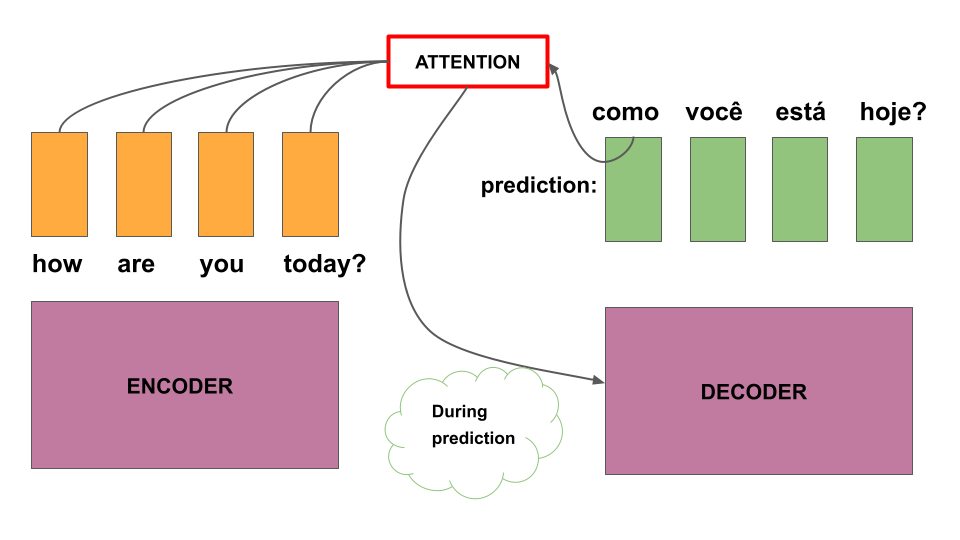

First we will define two important global variables:

- The size of the vocabulary
- The number of units in the LSTM layers (the same number will be used for all LSTM layers)

In this assignment, the vocabulary sizes for English and Portuguese are the same. Therefore, we use a single constant VOCAB_SIZE throughout the notebook. While in other settings, vocabulary sizes could differ, that is not the case in our assignment.

In [ ]:
VOCAB_SIZE = 12000
UNITS = 256

<a name="ex1"></a>
## 2.1 - Encoder

Our first exercise is to code the encoder part of the neural network. For this, complete the `Encoder` class below. Notice that in the constructor (the `__init__` method) we need to define all of the sublayers of the encoder and then use these sublayers during the forward pass (the `call` method).

The encoder consists of the following layers:

- [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). For this layer we need to define the appropriate `input_dim` and `output_dim` and let it know that we are using '0' as padding, which can be done by using the appropriate value for the `mask_zero` parameter.
    
+ [Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). In TF we can implement bidirectional behaviour for RNN-like layers. This part is already taken care of but we will need to specify the appropriate type of layer as well as its parameters. In particular we need to set the appropriate number of units and make sure that the LSTM returns the full sequence and not only the last output, which can be done by using the appropriate value for the `return_sequences` parameter.

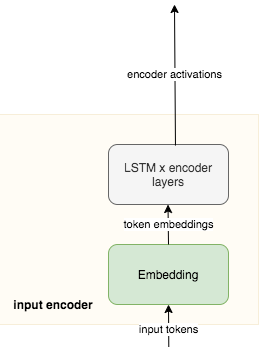

We need to define the forward pass using the syntax of TF's [functional API](https://www.tensorflow.org/guide/keras/functional_api). What this means is that we chain function calls together to define our network like this:

```python
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)
```

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, units):
        super(Encoder, self).__init__()

        self.embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=units,
            mask_zero=True
        )

        self.rnn = tf.keras.layers.Bidirectional(
            layer=tf.keras.layers.LSTM(
                units=units,
                return_sequences=True
            ),
            merge_mode="sum"
        )

    def call(self, context):
        x = self.embedding(context)
        x = self.rnn(x)
        return x

In [ ]:
# Do a quick check of your implementation

# Create an instance of your class
encoder = Encoder(VOCAB_SIZE, UNITS)

# Pass a batch of sentences to translate from english to portuguese
encoder_output = encoder(to_translate)

print(f'Tensor of sentences in english has shape: {to_translate.shape}\n')
print(f'Encoder output has shape: {encoder_output.shape}')

Tensor of sentences in english has shape: (64, 14)

Encoder output has shape: (64, 14, 256)


##### __Expected Output__

```
Tensor of sentences in english has shape: (64, 14)

Encoder output has shape: (64, 14, 256)
```

In [ ]:
# Test your code!

w1_unittest.test_encoder(Encoder)

 All tests passed!


<a name="ex2"></a>
## 2.2 - CrossAttention

Our next exercise is to code the layer that will perform cross attention between the original sentences and the translations. For this, complete the `CrossAttention` class below. Notice that in the constructor (the `__init__` method) we need to define all of the sublayers and then use these sublayers during the forward pass (the `call` method). For this particular case some of these bits are already taken care of.

The cross attention consists of the following layers:

- [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). For this layer we need to define the appropriate `key_dim`, which is the size of the key and query tensors. We will also need to set the number of heads to 1 since we aren't implementing multi head attention but attention between two tensors. The reason why this layer is preferred over [Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention) is that it allows simpler code during the forward pass.
    
A couple of things to notice:
- We need a way to pass both the output of the attention alongside the shifted-to-the-right translation (since this cross attention happens in the decoder side). For this we will use an [Add](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add) layer so that the original dimension is preserved, which would not happen if we use something like a [Concatenate](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate) layer.

+ Layer normalization is also performed for better stability of the network by using a [LayerNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization) layer.

- We don't need to worry about these last steps as these are already solved.



In [ ]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
            key_dim=units,
            num_heads=1
        )

        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, context, target):
        attn_output = self.mha(query=target, value=context, key=context)
        x = self.add([target, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
# Do a quick check of your implementation

# Create an instance of your class
attention_layer = CrossAttention(UNITS)

# The attention layer expects the embedded sr-translation and the context
# The context (encoder_output) is already embedded so you need to do this for sr_translation:
sr_translation_embed = tf.keras.layers.Embedding(VOCAB_SIZE, output_dim=UNITS, mask_zero=True)(sr_translation)

# Compute the cross attention
attention_result = attention_layer(encoder_output, sr_translation_embed)

print(f'Tensor of contexts has shape: {encoder_output.shape}')
print(f'Tensor of translations has shape: {sr_translation_embed.shape}')
print(f'Tensor of attention scores has shape: {attention_result.shape}')

Tensor of contexts has shape: (64, 14, 256)
Tensor of translations has shape: (64, 15, 256)
Tensor of attention scores has shape: (64, 15, 256)


##### __Expected Output__

```
Tensor of contexts has shape: (64, 14, 256)
Tensor of translations has shape: (64, 15, 256)
Tensor of attention scores has shape: (64, 15, 256)
```

In [ ]:
# Test your code!

w1_unittest.test_cross_attention(CrossAttention)

 All tests passed!


<a name="ex3"></a>
## 2.3 - Decoder


Now we will implement the decoder part of the neural network by completing the `Decoder` class below. Notice that in the constructor (the `__init__` method) we need to define all of the sublayers of the decoder and then use these sublayers during the forward pass (the `call` method).

The decoder consists of the following layers:

- [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). For this layer we need to define the appropriate `input_dim` and `output_dim` and let it know that we are using '0' as padding, which can be done by using the appropriate value for the `mask_zero` parameter.
  
  
+ Pre-attention [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Unlike in the encoder in which we used a Bidirectional LSTM, here we will use a vanilla LSTM. Don't forget to set the appropriate number of units and make sure that the LSTM returns the full sequence and not only the last output, which can be done by using the appropriate value for the `return_sequences` parameter. It is very important that this layer returns the state since this will be needed for inference so make sure to set the `return_state` parameter accordingly. Notice that LSTM layers return state as a tuple of two tensors called `memory_state` and `carry_state`, **however these names have been changed to better reflect what we have seen in the lectures to `hidden_state` and `cell_state` respectively**.

- The attention layer that performs cross attention between the sentence to translate and the right-shifted translation. Here we need to use the `CrossAttention` layer we defined in the previous exercise.

+ Post-attention [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Another LSTM layer. For this one we don't need it to return the state.

- Finally a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer. This one should have the same number of units as the size of the vocabulary since we expect it to compute the logits for every possible word in the vocabulary. Make sure to use a `logsoftmax` activation function for this one, which we can get as [tf.nn.log_softmax](https://www.tensorflow.org/api_docs/python/tf/nn/log_softmax).



In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, units):
        super(Decoder, self).__init__()

        self.embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=units,
            mask_zero=True
        )

        self.pre_attention_rnn = tf.keras.layers.LSTM(
            units=units,
            return_sequences=True,
            return_state=True
        )

        self.attention = CrossAttention(units)

        self.post_attention_rnn = tf.keras.layers.LSTM(
            units=units,
            return_sequences=True
        )

        self.output_layer = tf.keras.layers.Dense(
            units=vocab_size,
            activation=tf.nn.log_softmax
        )


    def call(self, context, target, state=None, return_state=False):
        x = self.embedding(target)
        x, hidden_state, cell_state = self.pre_attention_rnn(x, initial_state=state)
        x = self.attention(context, x)
        x = self.post_attention_rnn(x)
        logits = self.output_layer(x)

        if return_state:
            return logits, [hidden_state, cell_state]

        return logits

In [ ]:
# Do a quick check of your implementation

# Create an instance of your class
decoder = Decoder(VOCAB_SIZE, UNITS)

# Notice that you don't need the embedded version of sr_translation since this is done inside the class
logits = decoder(encoder_output, sr_translation)

print(f'Tensor of contexts has shape: {encoder_output.shape}')
print(f'Tensor of right-shifted translations has shape: {sr_translation.shape}')
print(f'Tensor of logits has shape: {logits.shape}')

Tensor of contexts has shape: (64, 14, 256)
Tensor of right-shifted translations has shape: (64, 15)
Tensor of logits has shape: (64, 15, 12000)


##### __Expected Output__

```
Tensor of contexts has shape: (64, 14, 256)
Tensor of right-shifted translations has shape: (64, 15)
Tensor of logits has shape: (64, 15, 12000)
```

In [ ]:
# Test your code!

w1_unittest.test_decoder(Decoder, CrossAttention)

 All tests passed!


<a name="ex4"></a>
## 2.4 - Translator

Now we have to put together all of the layers we previously coded into an actual model. For this, complete the `Translator` class below. Notice how unlike the Encoder and Decoder classes inherited from `tf.keras.layers.Layer`, the Translator class inherits from `tf.keras.Model`.

Remember that `train_data` will yield a tuple with the sentence to translate and the shifted-to-the-right translation, which are the "features" of the model. This means that the inputs of our network will be tuples containing context and targets.

In [ ]:
class Translator(tf.keras.Model):
    def __init__(self, vocab_size, units):
        super().__init__()
        self.encoder = Encoder(vocab_size, units)
        self.decoder = Decoder(vocab_size, units)

    def call(self, inputs):
        context, target = inputs
        encoded_context = self.encoder(context)
        logits = self.decoder(encoded_context, target)

        return logits

In [ ]:
# Do a quick check of your implementation

# Create an instance of your class
translator = Translator(VOCAB_SIZE, UNITS)

# Compute the logits for every word in the vocabulary
logits = translator((to_translate, sr_translation))

print(f'Tensor of sentences to translate has shape: {to_translate.shape}')
print(f'Tensor of right-shifted translations has shape: {sr_translation.shape}')
print(f'Tensor of logits has shape: {logits.shape}')

Tensor of sentences to translate has shape: (64, 14)
Tensor of right-shifted translations has shape: (64, 15)
Tensor of logits has shape: (64, 15, 12000)


##### __Expected Output__

```
Tensor of sentences to translate has shape: (64, 14)
Tensor of right-shifted translations has shape: (64, 15)
Tensor of logits has shape: (64, 15, 12000)
```

In [ ]:
w1_unittest.test_translator(Translator, Encoder, Decoder)

 All tests passed!


<a name="3"></a>
## 3. Training

Now that we have an untrained instance of the NMT model, it is time to train it. We can use the `compile_and_train` function below to achieve this:

In [ ]:
def compile_and_train(model, epochs=20, steps_per_epoch=500):
    model.compile(optimizer="adam", loss=masked_loss, metrics=[masked_acc, masked_loss])

    history = model.fit(
        train_data.repeat(),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_data,
        validation_steps=50,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    )

    return model, history

In [ ]:
# Train the translator (this takes some minutes so feel free to take a break)

trained_translator, history = compile_and_train(translator)

Epoch 1/20
500/500 [==============================] - 47s 67ms/step - loss: 5.2181 - masked_acc: 0.2098 - masked_loss: 5.2206 - val_loss: 4.5361 - val_masked_acc: 0.2928 - val_masked_loss: 4.5371
Epoch 2/20
500/500 [==============================] - 17s 33ms/step - loss: 3.9271 - masked_acc: 0.3907 - masked_loss: 3.9278 - val_loss: 3.2005 - val_masked_acc: 0.4822 - val_masked_loss: 3.2021
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 2.8525 - masked_acc: 0.5299 - masked_loss: 2.8540 - val_loss: 2.4741 - val_masked_acc: 0.5723 - val_masked_loss: 2.4747
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 2.2787 - masked_acc: 0.6090 - masked_loss: 2.2796 - val_loss: 2.0086 - val_masked_acc: 0.6466 - val_masked_loss: 2.0093
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 1.9090 - masked_acc: 0.6615 - masked_loss: 1.9102 - val_loss: 1.7454 - val_masked_acc: 0.6786 - val_masked_loss: 1.7460
Epoch 6/20
500/500 [

<a name="4"></a>
## 4. Using the model for inference


Now that our model is trained we can use it for inference. To help we with this the `generate_next_token` function is provided. Notice that this function is meant to be used inside a for-loop, so we feed to it the information of the previous step to generate the information of the next step. In particular we need to keep track of the state of the pre-attention LSTM in the decoder and if we are done with the translation. Also notice that a `temperature` variable is introduced which determines how to select the next token given the predicted logits:  

In [ ]:
def generate_next_token(decoder, context, next_token, done, state, temperature=0.0):
    """Generates the next token in the sequence

    Args:
        decoder (Decoder): The decoder
        context (tf.Tensor): Encoded sentence to translate
        next_token (tf.Tensor): The predicted next token
        done (bool): True if the translation is complete
        state (list[tf.Tensor, tf.Tensor]): Hidden states of the pre-attention LSTM layer
        temperature (float, optional): The temperature that controls the randomness of the predicted tokens. Defaults to 0.0.

    Returns:
        tuple(tf.Tensor, np.float, list[tf.Tensor, tf.Tensor], bool): The next token, log prob of said token, hidden state of LSTM and if translation is done
    """
    # Get the logits and state from the decoder
    logits, state = decoder(context, next_token, state=state, return_state=True)

    # Trim the intermediate dimension
    logits = logits[:, -1, :]

    # If temp is 0 then next_token is the argmax of logits
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)

    # If temp is not 0 then next_token is sampled out of logits
    else:
        logits = logits / temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # Trim dimensions of size 1
    logits = tf.squeeze(logits)
    next_token = tf.squeeze(next_token)

    # Get the logit of the selected next_token
    logit = logits[next_token].numpy()

    # Reshape to (1,1) since this is the expected shape for text encoded as TF tensors
    next_token = tf.reshape(next_token, shape=(1,1))

    # If next_token is End-of-Sentence token you are done
    if next_token == eos_id:
        done = True

    return next_token, logit, state, done

See how it works by running the following cell:

In [ ]:
# PROCESS SENTENCE TO TRANSLATE AND ENCODE

# A sentence you wish to translate
eng_sentence = "I love languages"

# Convert it to a tensor
texts = tf.convert_to_tensor(eng_sentence)[tf.newaxis]

# Vectorize it and pass it through the encoder
context = english_vectorizer(texts).to_tensor()
context = encoder(context)

# SET STATE OF THE DECODER

# Next token is Start-of-Sentence since you are starting fresh
next_token = tf.fill((1,1), sos_id)

# Hidden and Cell states of the LSTM can be mocked using uniform samples
state = [tf.random.uniform((1, UNITS)), tf.random.uniform((1, UNITS))]

# You are not done until next token is EOS token
done = False

# Generate next token
next_token, logit, state, done = generate_next_token(decoder, context, next_token, done, state, temperature=0.5)
print(f"Next token: {next_token}\nLogit: {logit:.4f}\nDone? {done}")

Next token: [[6188]]
Logit: -18.7795
Done? False


<a name="ex5"></a>
## 4.1 - translate

Now we can put everything together to translate a given sentence. For this, complete the `translate` function below. This function will take care of the following steps:
- Process the sentence to translate and encode it

+ Set the initial state of the decoder

- Get predictions of the next token (starting with the \<SOS> token) for a maximum of iterations (in case the \<EOS> token is never returned)
    
+ Return the translated text (as a string), the logit of the last iteration (this helps measure how certain was that the sequence was translated in its totality) and the translation in token format.


Hints:

- The previous cell provides a lot of insights on how this function should work, so if we get stuck refer to it.

+ Some useful docs:
    + [tf.newaxis](https://www.tensorflow.org/api_docs/python/tf#newaxis)

    - [tf.fill](https://www.tensorflow.org/api_docs/python/tf/fill)

    + [tf.zeros](https://www.tensorflow.org/api_docs/python/tf/zeros)


**IMPORTANT NOTE**: Due to randomness processes involving tensorflow training and weight initializing, the results below may vary a lot, even if we retrain our model in the same session.


In [ ]:
def translate(model, text, max_length=50, temperature=0.0):
    tokens, logits = [], []
    text = tf.convert_to_tensor(text)[tf.newaxis]
    context = english_vectorizer(text).to_tensor()
    context = model.encoder(context)
    next_token = tf.fill((1, 1), sos_id)
    state = [tf.zeros((1, UNITS)), tf.zeros((1, UNITS))]

    done = False

    for _ in range(max_length):
        try:
            next_token, logit, state, done = generate_next_token(
                decoder=model.decoder,
                context=context,
                next_token=next_token,
                done=done,
                state=state,
                temperature=temperature
            )
        except:
            raise Exception("Problem generating the next token")

        if done:
            break

        tokens.append(next_token)
        logits.append(logit)

    tokens = tf.concat(tokens, axis=-1)

    translation = tf.squeeze(tokens_to_text(tokens, id_to_word))
    translation = translation.numpy().decode()

    return translation, logits[-1], tokens

Try our function with temperature of 0, which will yield a deterministic output and is equivalent to a greedy decoding:

In [ ]:
# Running this cell multiple times should return the same output since temp is 0

temp = 0.0
original_sentence = "I love languages"

translation, logit, tokens = translate(trained_translator, original_sentence, temperature=temp)

print(f"Temperature: {temp}\n\nOriginal sentence: {original_sentence}\nTranslation: {translation}\nTranslation tokens:{tokens}\nLogit: {logit:.3f}")

Temperature: 0.0

Original sentence: I love languages
Translation: eu eu amo idiomas sao doze anos .
Translation tokens:[[   9    9  522  850   72 2644  134    4]]
Logit: -0.230


Try our function with temperature of 0.7 (stochastic output):

In [ ]:
# Running this cell multiple times should return different outputs since temp is not 0
# You can try different temperatures

temp = 0.7
original_sentence = "I love languages"

translation, logit, tokens = translate(trained_translator, original_sentence, temperature=temp)

print(f"Temperature: {temp}\n\nOriginal sentence: {original_sentence}\nTranslation: {translation}\nTranslation tokens:{tokens}\nLogit: {logit:.3f}")

Temperature: 0.7

Original sentence: I love languages
Translation: eu eu adoro idiomas mundial .
Translation tokens:[[   9    9  564  850 2787    4]]
Logit: -1.575


In [ ]:
w1_unittest.test_translate(translate, trained_translator)

 All tests passed!


<a name="5"></a>
## 5. Minimum Bayes-Risk Decoding

As mentioned in the lectures, getting the most probable token at each step may not necessarily produce the best results. Another approach is to do Minimum Bayes Risk Decoding or MBR. The general steps to implement this are:

- Take several random samples
+ Score each sample against all other samples
- Select the one with the highest score

We will be building helper functions for these steps in the following sections.

With the ability to generate different translations by setting different temperature values we can do what we saw in the lectures and generate a bunch of translations and then determine which one is the best candidate. We will now do this by using the provided `generate_samples` function. This function will return any desired number of candidate translations alongside the log-probability for each one:

In [ ]:
def generate_samples(model, text, n_samples=4, temperature=0.6):

    samples, log_probs = [], []

    # Iterate for n_samples iterations
    for _ in range(n_samples):

        # Save the logit and the translated tensor
        _, logp, sample = translate(model, text, temperature=temperature)

        # Save the translated tensors
        samples.append(np.squeeze(sample.numpy()).tolist())

        # Save the logits
        log_probs.append(logp)

    return samples, log_probs

In [ ]:
samples, log_probs = generate_samples(trained_translator, 'I love languages')

for s, l in zip(samples, log_probs):
    print(f"Translated tensor: {s} has logit: {l:.3f}")

Translated tensor: [9, 522, 850, 72, 850, 4] has logit: -1.544
Translated tensor: [9, 9, 522, 850, 72, 495, 4] has logit: -0.466
Translated tensor: [9, 522, 1032, 7179, 4] has logit: -0.132
Translated tensor: [9, 564, 850, 164, 2779, 17, 4] has logit: -1.439


## Comparing overlaps

Now that we can generate multiple translations it is time to come up with a method to measure the goodness of each one. As we saw in the lectures, one way to achieve this is by comparing each sample against the others.

There are several metrics we can use for this purpose, as shown in the lectures and we can try experimenting with any one of these. For this assignment, we will be calculating scores for **unigram overlaps**.

One of these metrics is the widely used yet simple [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) which gets the intersection over union of two sets. The `jaccard_similarity` function returns this metric for any pair of candidate and reference translations:


In [ ]:
def jaccard_similarity(candidate, reference):

    # Convert the lists to sets to get the unique tokens
    candidate_set = set(candidate)
    reference_set = set(reference)

    # Get the set of tokens common to both candidate and reference
    common_tokens = candidate_set.intersection(reference_set)

    # Get the set of all tokens found in either candidate or reference
    all_tokens = candidate_set.union(reference_set)

    # Compute the percentage of overlap (divide the number of common tokens by the number of all tokens)
    overlap = len(common_tokens) / len(all_tokens)

    return overlap

In [ ]:
l1 = [1, 2, 3]
l2 = [1, 2, 3, 4]

js = jaccard_similarity(l1, l2)

print(f"jaccard similarity between lists: {l1} and {l2} is {js:.3f}")

jaccard similarity between lists: [1, 2, 3] and [1, 2, 3, 4] is 0.750


##### __Expected Output__

```
jaccard similarity between tensors: [1, 2, 3] and [1, 2, 3, 4] is 0.750

```

<a name="ex6"></a>
## 5.1 - rouge1_similarity

Jaccard similarity is good but a more commonly used metric in machine translation is the ROUGE score. For unigrams, this is called ROUGE-1 and as shown in the lectures, we can output the scores for both precision and recall when comparing two samples. To get the final score, we will want to compute the F1-score as given by:

$$score = 2* \frac{(precision * recall)}{(precision + recall)}$$

For the implementation of the `rouge1_similarity` function we want to use the [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) class from the Python standard library:

In [ ]:
def rouge1_similarity(candidate, reference):
    candidate_word_counts = Counter(candidate)
    reference_word_counts = Counter(reference)

    overlap = 0

    for token in candidate_word_counts.keys():
        token_count_candidate = candidate_word_counts[token]
        token_count_reference = reference_word_counts[token]
        overlap += min(token_count_candidate, token_count_reference)

    precision = overlap / len(candidate) if len(candidate) > 0 else 0
    recall = overlap / len(reference) if len(reference) > 0 else 0

    if precision + recall != 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
        return f1_score

    return 0

In [ ]:
l1 = [1, 2, 3]
l2 = [1, 2, 3, 4]

r1s = rouge1_similarity(l1, l2)

print(f"rouge 1 similarity between lists: {l1} and {l2} is {r1s:.3f}")

rouge 1 similarity between lists: [1, 2, 3] and [1, 2, 3, 4] is 0.857


##### __Expected Output__

```
rouge 1 similarity between lists: [1, 2, 3] and [1, 2, 3, 4] is 0.857

```

In [ ]:
w1_unittest.test_rouge1_similarity(rouge1_similarity)

 All tests passed!


## Computing the Overall Score


We will now build a function to generate the overall score for a particular sample. As mentioned in the lectures, we need to compare each sample with all other samples. For instance, if we generated 30 sentences, we will need to compare sentence 1 to sentences 2 through 30. Then, we compare sentence 2 to sentences 1 and 3 through 30, and so forth. At each step, we get the average score of all comparisons to get the overall score for a particular sample. To illustrate, these will be the steps to generate the scores of a 4-sample list.

- Get similarity score between sample 1 and sample 2
+ Get similarity score between sample 1 and sample 3
- Get similarity score between sample 1 and sample 4
+ Get average score of the first 3 steps. This will be the overall score of sample 1
- Iterate and repeat until samples 1 to 4 have overall scores.


The results will be stored in a dictionary for easy lookups.

<a name="ex7"></a>
## 5.2 - average_overlap

Complete the `average_overlap` function below which should implement the process described above:

In [ ]:
def average_overlap(samples, similarity_fn):
    """Computes the arithmetic mean of each candidate sentence in the samples

    Args:
        samples (list[list[int]]): Tokenized version of translated sentences
        similarity_fn (Function): Similarity function used to compute the overlap

    Returns:
        dict[int, float]: A dictionary mapping the index of each translation to its score
    """
    scores = {}

    for index_candidate, candidate in enumerate(samples):
        overlap = 0

        for index_sample, sample in enumerate(samples):

            if index_candidate == index_sample:
                continue

            sample_overlap = similarity_fn(candidate, sample)
            overlap += sample_overlap

        score = overlap / (len(samples) - 1)
        score = round(score, 3)
        scores[index_candidate] = score

    return scores

In [ ]:
# Test with Jaccard similarity

l1 = [1, 2, 3]
l2 = [1, 2, 4]
l3 = [1, 2, 4, 5]

avg_ovlp = average_overlap([l1, l2, l3], jaccard_similarity)

print(f"average overlap between lists: {l1}, {l2} and {l3} using Jaccard similarity is:\n\n{avg_ovlp}")

average overlap between lists: [1, 2, 3], [1, 2, 4] and [1, 2, 4, 5] using Jaccard similarity is:

{0: 0.45, 1: 0.625, 2: 0.575}


##### __Expected Output__

```
average overlap between lists: [1, 2, 3], [1, 2, 4] and [1, 2, 4, 5] using Jaccard similarity is:

{0: 0.45, 1: 0.625, 2: 0.575}
```

In [ ]:
# Test with Rouge1 similarity

l1 = [1, 2, 3]
l2 = [1, 4]
l3 = [1, 2, 4, 5]
l4 = [5,6]

avg_ovlp = average_overlap([l1, l2, l3, l4], rouge1_similarity)

print(f"average overlap between lists: {l1}, {l2}, {l3} and {l4} using Rouge1 similarity is:\n\n{avg_ovlp}")

average overlap between lists: [1, 2, 3], [1, 4], [1, 2, 4, 5] and [5, 6] using Rouge1 similarity is:

{0: 0.324, 1: 0.356, 2: 0.524, 3: 0.111}


##### __Expected Output__

```
average overlap between lists: [1, 2, 3], [1, 4], [1, 2, 4, 5] and [5, 6] using Rouge1 similarity is:

{0: 0.324, 1: 0.356, 2: 0.524, 3: 0.111}
```

In [ ]:
w1_unittest.test_average_overlap(average_overlap)

 All tests passed!


In practice, it is also common to see the weighted mean being used to calculate the overall score instead of just the arithmetic mean. This is implemented in the `weighted_avg_overlap` function below and we can use it in our experiments to see which one will give better results:

In [ ]:
def weighted_avg_overlap(samples, log_probs, similarity_fn):

    # Scores dictionary
    scores = {}

    # Iterate over the samples
    for index_candidate, candidate in enumerate(samples):

        # Initialize overlap and weighted sum
        overlap, weight_sum = 0.0, 0.0

        # Iterate over all samples and log probabilities
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):

            # Skip if the candidate index is the same as the sample index
            if index_candidate == index_sample:
                continue

            # Convert log probability to linear scale
            sample_p = float(np.exp(logp))

            # Update the weighted sum
            weight_sum += sample_p

            # Get the unigram overlap between candidate and sample
            sample_overlap = similarity_fn(candidate, sample)

            # Update the overlap
            overlap += sample_p * sample_overlap

        # Compute the score for the candidate
        score = overlap / weight_sum

        # Only use 3 decimal points
        score = round(score, 3)

        # Save the score in the dictionary. use index as the key.
        scores[index_candidate] = score

    return scores

In [ ]:
l1 = [1, 2, 3]
l2 = [1, 2, 4]
l3 = [1, 2, 4, 5]
log_probs = [0.4, 0.2, 0.5]

w_avg_ovlp = weighted_avg_overlap([l1, l2, l3], log_probs, jaccard_similarity)

print(f"weighted average overlap using Jaccard similarity is:\n\n{w_avg_ovlp}")

weighted average overlap using Jaccard similarity is:

{0: 0.443, 1: 0.631, 2: 0.558}


## mbr_decode

We will now put everything together in the the `mbr_decode` function below. This final step is not graded as this function is just a wrapper around all the cool stuff we have coded so far!

We can use it to play around, trying different numbers of samples, temperatures and similarity functions!

In [ ]:
def mbr_decode(model, text, n_samples=5, temperature=0.6, similarity_fn=jaccard_similarity):

    # Generate samples
    samples, log_probs = generate_samples(model, text, n_samples=n_samples, temperature=temperature)

    # Compute the overlap scores
    scores = weighted_avg_overlap(samples, log_probs, similarity_fn)

    # Decode samples
    decoded_translations = [tokens_to_text(s, id_to_word).numpy().decode('utf-8') for s in samples]

    # Find the key with the highest score
    max_score_key = max(scores, key=lambda k: scores[k])

    # Get the translation
    translation = decoded_translations[max_score_key]

    return translation, decoded_translations

In [ ]:
english_sentence = "I love languages"

translation, candidates = mbr_decode(trained_translator, english_sentence, n_samples=10, temperature=0.6)

print("Translation candidates:")
for c in candidates:
    print(c)

print(f"\nSelected translation: {translation}")

Translation candidates:
eu eu amo idiomas eram quatro anos .
eu adoro idiomas que eu estamos idiomas .
eu adoro idiomas sao doze estacoes .
eu eu adoro idiomas chega .
eu eu amo linguas .
eu eu adoro linguas valiosa .
eu eu eu amo idiomas elas desapareceram .
eu eu adoro idiomas voce mede alguma linguas .
eu eu amo idiomas sao doze anos .
eu eu amo idiomas sao doze linguas .

Selected translation: eu eu amo idiomas sao doze linguas .
